# Megawatt (MW) Prediction Using Machine Learning and Deep Learning Models

## Project Overview
This notebook implements a comprehensive analysis and prediction system for Megawatt (MW) consumption using various machine learning and deep learning models.

### Models Implemented:
- **Machine Learning**: SVR, Random Forest, XGBoost
- **Deep Learning**: LSTM, GRU

### Evaluation Metrics:
- RMSE (Root Mean Square Error)
- MAPE (Mean Absolute Percentage Error)
- MAE (Mean Absolute Error)
- MSE (Mean Square Error)
- R-squared

## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully!')

## 2. Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_excel('combinedMVWeatherData/combinedMVWeather.xlsx')

# Display basic information
print('Dataset Shape:', df.shape)
print('\nFirst few rows:')
print(df.head())
print('\nDataset Info:')
print(df.info())
print('\nStatistical Summary:')
print(df.describe())
print('\nMissing Values:')
print(df.isnull().sum())

Dataset Shape: (24528, 5)

First few rows:
               Time   MW  Air Temperature  Global Solar Radiation  \
0  2022-10-19 01:00  0.8            14.50                     0.0   
1  2022-10-19 02:00  0.8            14.40                     0.0   
2  2022-10-19 03:00  0.8            14.00                     0.0   
3  2022-10-19 04:00  0.8            13.20                     0.0   
4  2022-10-19 05:00  0.8            12.65                     0.0   

   Relative Humidity  
0               88.8  
1               87.9  
2               92.3  
3               95.8  
4               97.9  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24528 entries, 0 to 24527
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    24528 non-null  object 
 1   MW                      24408 non-null  float64
 2   Air Temperature         24528 non-null  float64
 3   Global Sola

## 3. Data Preprocessing

In [4]:
# Preprocessing for 'Time' column to handle '24:00' entries
# The ValueError occurs because '24:00' is not a valid hour in a 0-23 system.
# We will convert 'YYYY-MM-DD 24:00' to 'YYYY-MM-DD+1 00:00'.

# Ensure 'Time' column is string type for string operations
df['Time'] = df['Time'].astype(str)

# Create a boolean mask for entries containing ' 24:00'
mask_24h = df['Time'].str.contains(' 24:00')

if mask_24h.any():
    print(f"Found {mask_24h.sum()} entries with '24:00' in the 'Time' column. Correcting them...")

    # For these entries, replace '24:00' with '00:00'
    df.loc[mask_24h, 'Time'] = df.loc[mask_24h, 'Time'].str.replace(' 24:00', ' 00:00')

    # Convert these modified strings to datetime objects temporarily
    # This uses the default pandas parsing, which should now work for '00:00'
    temp_dt = pd.to_datetime(df.loc[mask_24h, 'Time'])

    # Add one day to these datetime objects
    temp_dt = temp_dt + pd.Timedelta(days=1)

    # Convert them back to the desired string format
    df.loc[mask_24h, 'Time'] = temp_dt.dt.strftime('%Y-%m-%d %H:%M')

    print("Correction completed: '24:00' entries are now '00:00' of the next day.")
else:
    print("No '24:00' entries found in the 'Time' column. No correction needed.")


Found 1022 entries with '24:00' in the 'Time' column. Correcting them...
Correction completed: '24:00' entries are now '00:00' of the next day.


In [5]:
# Make a copy of the dataset
data = df.copy()

# Convert Time column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Handle missing values in MW column
print(f'Missing MW values before: {data["MW"].isnull().sum()}')

# Fill missing MW values using interpolation
data['MW'] = data['MW'].interpolate(method='linear')

# If any remaining NaN values, use forward fill then backward fill
data['MW'].fillna(method='ffill', inplace=True)
data['MW'].fillna(method='bfill', inplace=True)

print(f'Missing MW values after: {data["MW"].isnull().sum()}')

# Extract time-based features
data['Hour'] = data['Time'].dt.hour
data['Day'] = data['Time'].dt.day
data['Month'] = data['Time'].dt.month
data['DayOfWeek'] = data['Time'].dt.dayofweek
data['DayOfYear'] = data['Time'].dt.dayofyear

# Create cyclical features for hour
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

# Create cyclical features for month
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

print('\nFeatures after preprocessing:')
print(data.columns.tolist())
print('\nData shape after feature engineering:', data.shape)

Missing MW values before: 120
Missing MW values after: 0

Features after preprocessing:
['Time', 'MW', 'Air Temperature', 'Global Solar Radiation', 'Relative Humidity', 'Hour', 'Day', 'Month', 'DayOfWeek', 'DayOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos']

Data shape after feature engineering: (24528, 14)


## 4. Exploratory Data Analysis (EDA) and Visualization

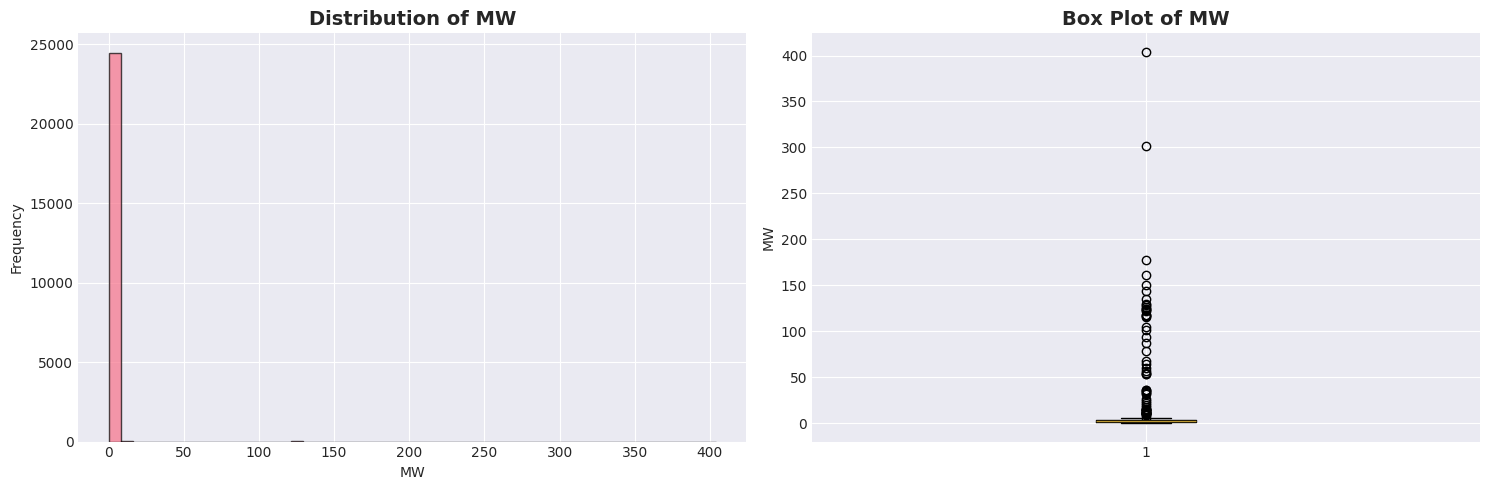

MW Statistics:
Mean: 2.52
Median: 2.30
Std Dev: 5.02
Min: 0.00
Max: 404.00


In [7]:
# Distribution of MW (target variable)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(data['MW'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of MW', fontsize=14, fontweight='bold')
axes[0].set_xlabel('MW')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(data['MW'])
axes[1].set_title('Box Plot of MW', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MW')

plt.tight_layout()
plt.show()

print(f'MW Statistics:')
print(f'Mean: {data["MW"].mean():.2f}')
print(f'Median: {data["MW"].median():.2f}')
print(f'Std Dev: {data["MW"].std():.2f}')
print(f'Min: {data["MW"].min():.2f}')
print(f'Max: {data["MW"].max():.2f}')

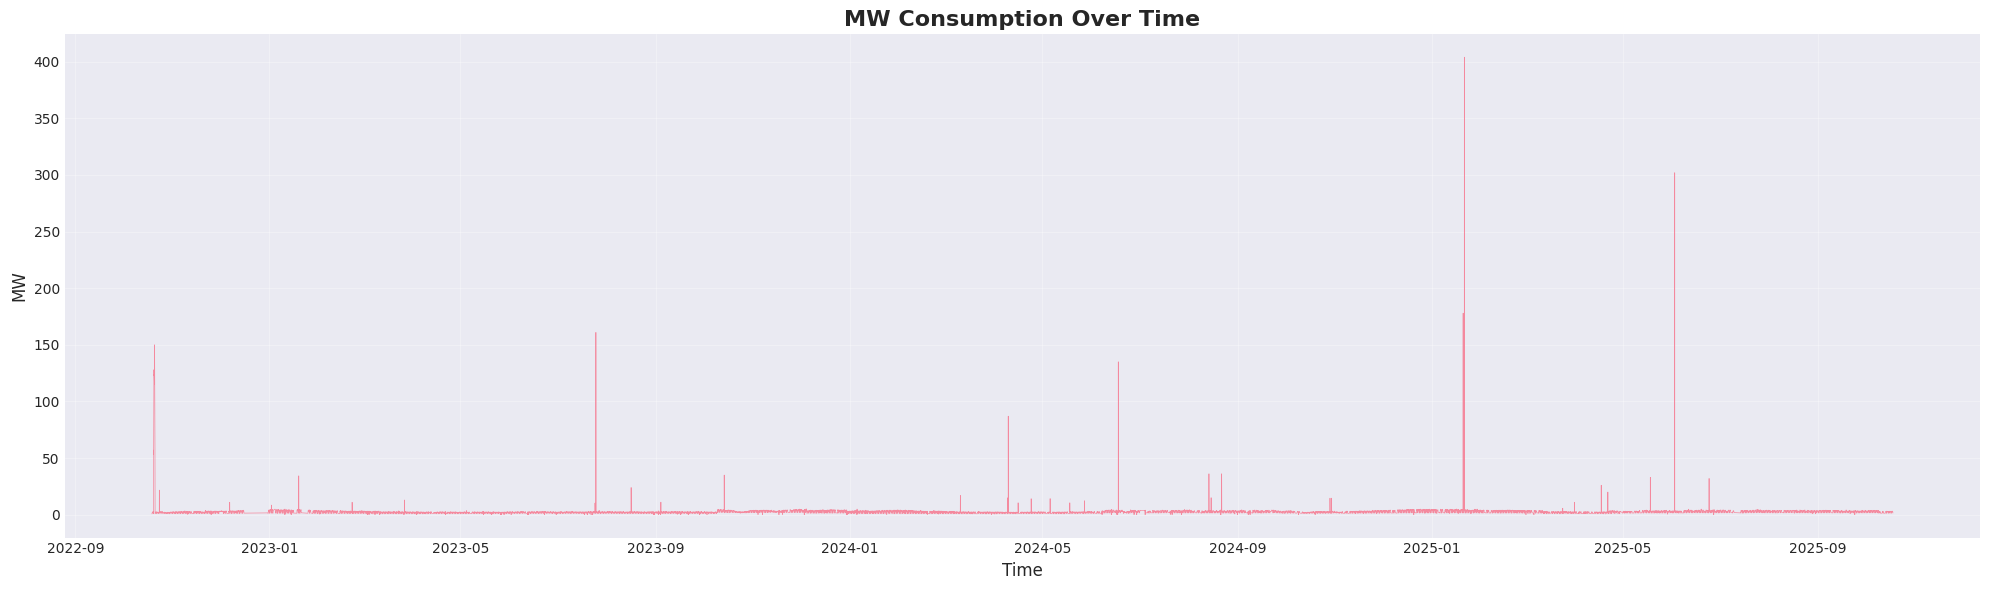

In [8]:
# Time series plot of MW
plt.figure(figsize=(20, 6))
plt.plot(data['Time'], data['MW'], linewidth=0.5, alpha=0.8)
plt.title('MW Consumption Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('MW', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

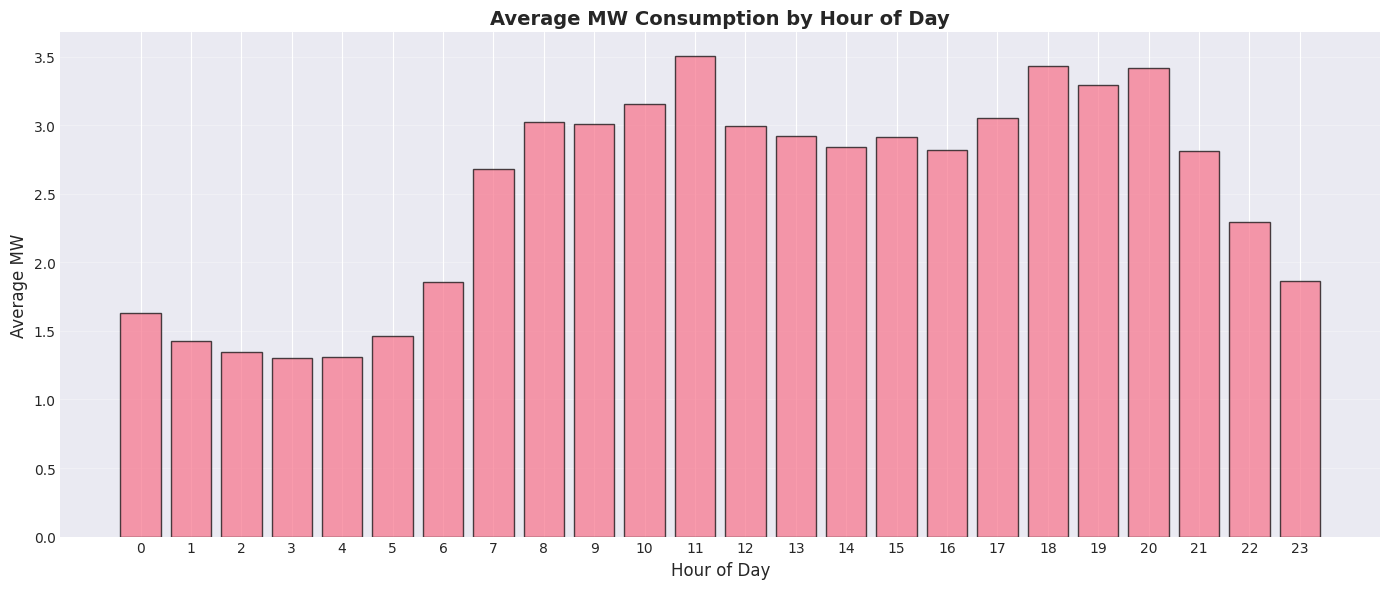

In [9]:
# MW consumption by hour of day
plt.figure(figsize=(14, 6))
hourly_avg = data.groupby('Hour')['MW'].mean()
plt.bar(hourly_avg.index, hourly_avg.values, alpha=0.7, edgecolor='black')
plt.title('Average MW Consumption by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average MW', fontsize=12)
plt.xticks(range(24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

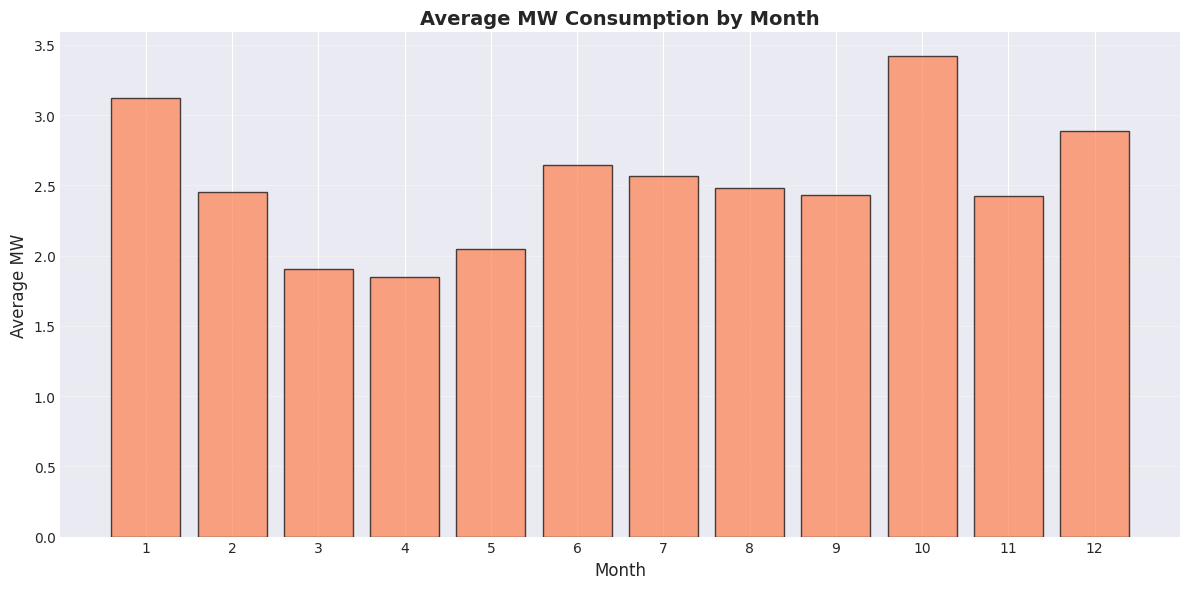

In [10]:
# MW consumption by month
plt.figure(figsize=(12, 6))
monthly_avg = data.groupby('Month')['MW'].mean()
plt.bar(monthly_avg.index, monthly_avg.values, alpha=0.7, edgecolor='black', color='coral')
plt.title('Average MW Consumption by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average MW', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

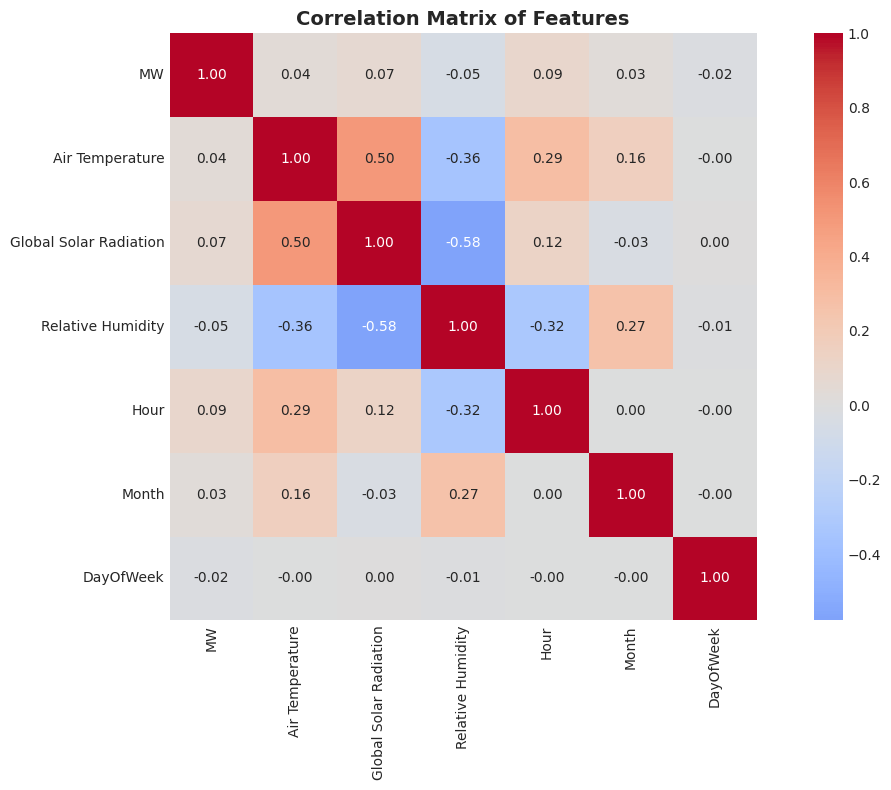

In [11]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = ['MW', 'Air Temperature', 'Global Solar Radiation', 'Relative Humidity', 'Hour', 'Month', 'DayOfWeek']
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Matrix of Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

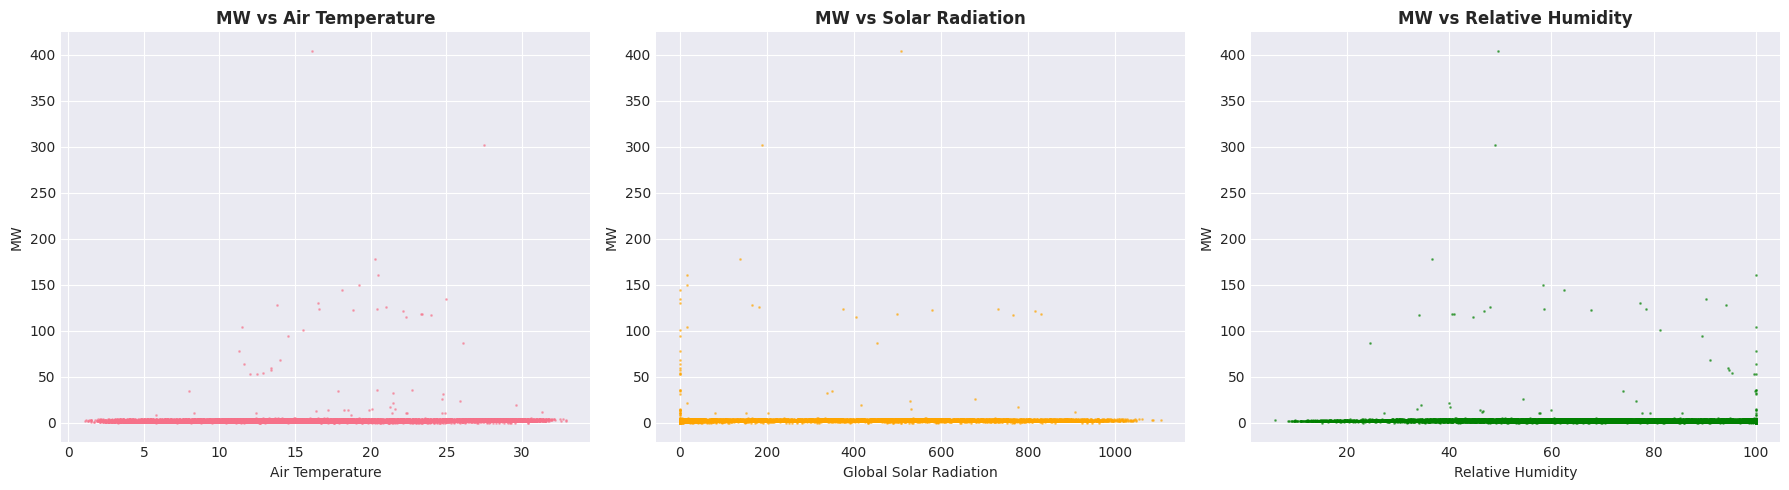

In [12]:
# Relationship between MW and weather features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MW vs Temperature
axes[0].scatter(data['Air Temperature'], data['MW'], alpha=0.5, s=1)
axes[0].set_title('MW vs Air Temperature', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Air Temperature')
axes[0].set_ylabel('MW')

# MW vs Solar Radiation
axes[1].scatter(data['Global Solar Radiation'], data['MW'], alpha=0.5, s=1, color='orange')
axes[1].set_title('MW vs Solar Radiation', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Global Solar Radiation')
axes[1].set_ylabel('MW')

# MW vs Humidity
axes[2].scatter(data['Relative Humidity'], data['MW'], alpha=0.5, s=1, color='green')
axes[2].set_title('MW vs Relative Humidity', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Relative Humidity')
axes[2].set_ylabel('MW')

plt.tight_layout()
plt.show()

## 5. Prepare Data for Modeling

In [13]:
# Define features for ML models
feature_cols = ['Air Temperature', 'Global Solar Radiation', 'Relative Humidity', 
                'Hour', 'Day', 'Month', 'DayOfWeek', 'DayOfYear',
                'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos']

X = data[feature_cols].values
y = data['MW'].values

# Split data into training and testing sets (80-20 split)
# Use shuffle=False to preserve temporal order in time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')
print(f'Number of features: {X_train.shape[1]}')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\nData scaling completed!')

Training set size: 19622 samples
Testing set size: 4906 samples
Number of features: 12

Data scaling completed!


## 6. Machine Learning Models

### 6.1 Support Vector Regression (SVR)

In [14]:
print('Training SVR model...')
svr_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Predictions
svr_train_pred = svr_model.predict(X_train_scaled)
svr_test_pred = svr_model.predict(X_test_scaled)

print('SVR model trained successfully!')

Training SVR model...
SVR model trained successfully!


### 6.2 Random Forest

Training Random Forest model...
Random Forest model trained successfully!


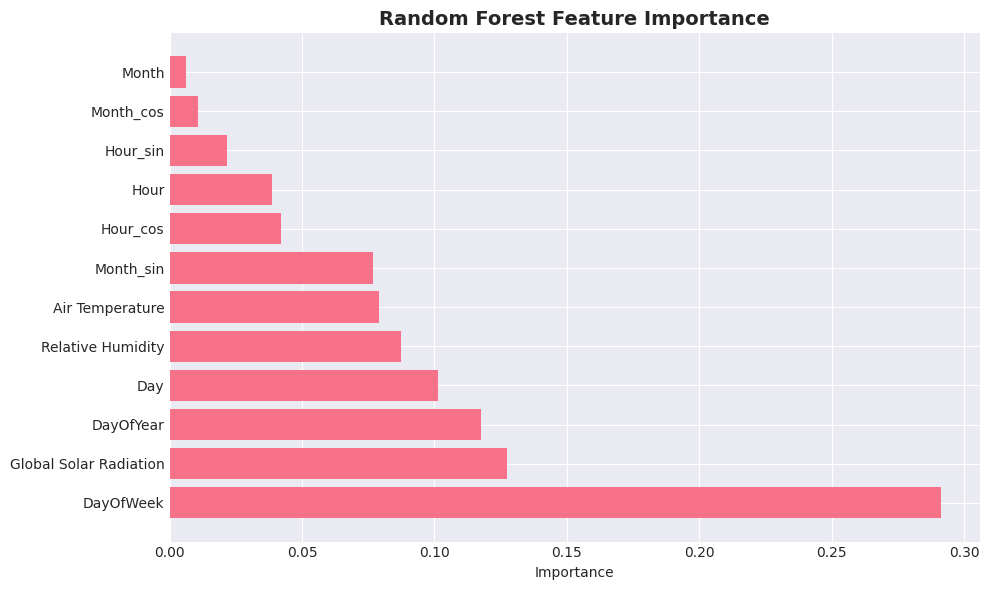

In [15]:
print('Training Random Forest model...')
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, 
                                  min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

print('Random Forest model trained successfully!')

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.3 XGBoost

In [16]:
print('Training XGBoost model...')
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, 
                         min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
                         random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)

print('XGBoost model trained successfully!')

Training XGBoost model...
XGBoost model trained successfully!


## 7. Deep Learning Models

In [17]:
# Prepare data for deep learning models (sequence format)
def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Use MinMaxScaler for deep learning models
scaler_dl = MinMaxScaler()
X_train_dl = scaler_dl.fit_transform(X_train)
X_test_dl = scaler_dl.transform(X_test)

# Create sequences (using 24-hour lookback)
time_steps = 24
X_train_seq, y_train_seq = create_sequences(X_train_dl, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_dl, y_test, time_steps)

print(f'Training sequences shape: {X_train_seq.shape}')
print(f'Testing sequences shape: {X_test_seq.shape}')

Training sequences shape: (19598, 24, 12)
Testing sequences shape: (4882, 24, 12)


### 7.1 LSTM Model

In [18]:
print('Building LSTM model...')

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(lstm_model.summary())

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print('\nTraining LSTM model...')
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
lstm_train_pred = lstm_model.predict(X_train_seq).flatten()
lstm_test_pred = lstm_model.predict(X_test_seq).flatten()

print('LSTM model trained successfully!')

Building LSTM model...


2025-11-25 16:50:50.550915: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,561 (525.63 KB)

 Trainable params: 134,561 (525.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM model...
Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 20.9560 - mae: 0.9625 - val_loss: 49.8851 - val_mae: 0.8994
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 20.4342 - mae: 0.7907 - val_loss: 49.5645 - val_mae: 0.8765
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 20.3668 - mae: 0.7630 - val_loss: 49.5079 - val_mae: 0.8718
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 20.2741 - mae: 0.7476 - val_loss: 50.1089 - val_mae: 0.9781
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 20.3132 - mae: 0.7597 - val_loss: 49.6173 - val_mae: 0.8425
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 20.2314 - mae: 0.7179 - val_loss: 49.2300 - val_mae: 0.6820
Epoch 7/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 20.2032 - mae: 0.7244 - val_loss: 49.2456 - val_mae: 0.7366
Epoch 8/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 20.1915 - mae: 0.7329 - val_loss: 49.5274 - val

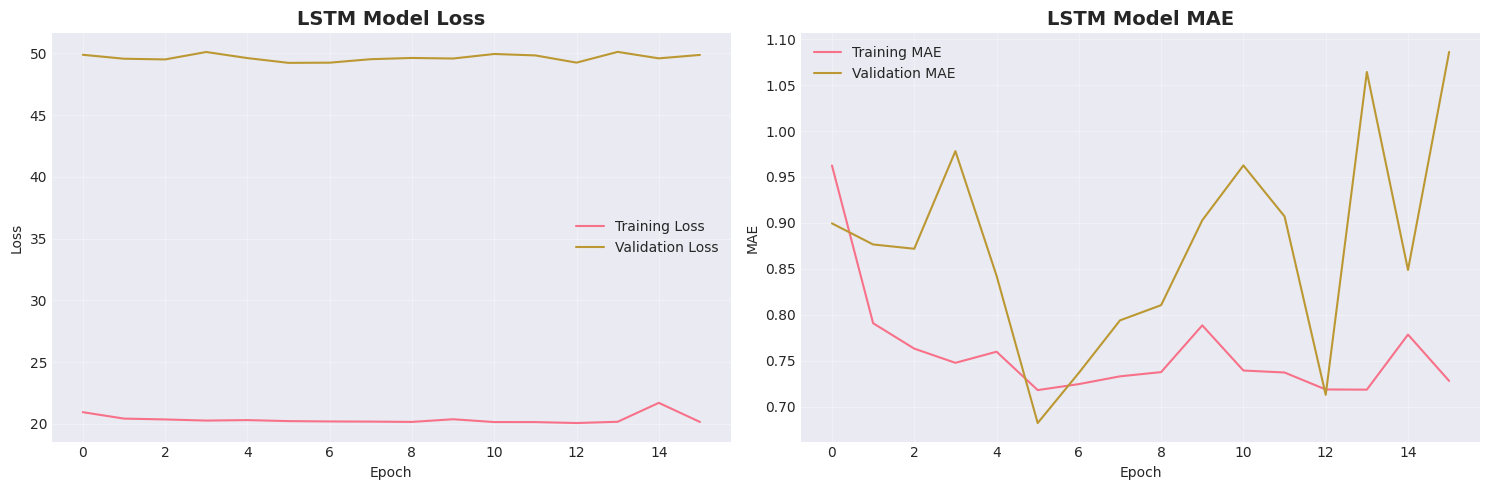

In [19]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(lstm_history.history['loss'], label='Training Loss')
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss')
axes[0].set_title('LSTM Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(lstm_history.history['mae'], label='Training MAE')
axes[1].plot(lstm_history.history['val_mae'], label='Validation MAE')
axes[1].set_title('LSTM Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 GRU Model

In [20]:
print('Building GRU model...')

# Build GRU model
gru_model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    GRU(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    GRU(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(gru_model.summary())

# Train the model
print('\nTraining GRU model...')
gru_history = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
gru_train_pred = gru_model.predict(X_train_seq).flatten()
gru_test_pred = gru_model.predict(X_test_seq).flatten()

print('GRU model trained successfully!')

Building GRU model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 128)        │        54,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 24, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,729 (397.38 KB)

 Trainable params: 101,729 (397.38 KB)

 Non-trainable params: 0 (0.00 B)

None

Training GRU model...
Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 20.7597 - mae: 0.9246 - val_loss: 49.7403 - val_mae: 0.8691
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 20.3898 - mae: 0.8245 - val_loss: 50.0141 - val_mae: 1.0699
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 20.4343 - mae: 0.7714 - val_loss: 49.8624 - val_mae: 0.8848
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 20.2909 - mae: 0.7345 - val_loss: 49.6293 - val_mae: 0.9216
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 20.2529 - mae: 0.7144 - val_loss: 49.7218 - val_mae: 0.9513
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 20.2253 - mae: 0.7206 - val_loss: 49.5533 - val_mae: 0.8668
Epoch 7/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 20.1606 - mae: 0.7266 - val_loss: 49.2218 - val_mae: 0.7117
Epoch 8/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 20.0848 - mae: 0.7171 - val_loss: 49.3989 - val_

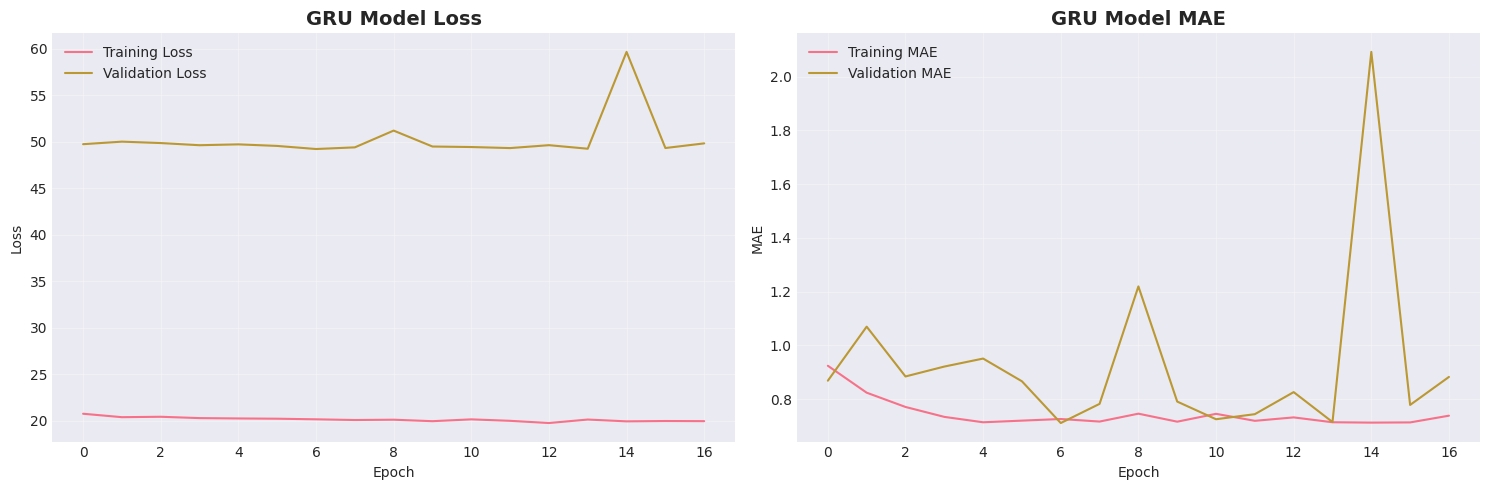

In [21]:
# Plot GRU training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(gru_history.history['loss'], label='Training Loss')
axes[0].plot(gru_history.history['val_loss'], label='Validation Loss')
axes[0].set_title('GRU Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(gru_history.history['mae'], label='Training MAE')
axes[1].plot(gru_history.history['val_mae'], label='Validation MAE')
axes[1].set_title('GRU Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Evaluation and Comparison

In [22]:
# Evaluation metrics functions
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'MAPE': mape
    }

# Calculate metrics for all models
results = {}

# SVR
results['SVR'] = {
    'Train': calculate_metrics(y_train, svr_train_pred),
    'Test': calculate_metrics(y_test, svr_test_pred)
}

# Random Forest
results['Random Forest'] = {
    'Train': calculate_metrics(y_train, rf_train_pred),
    'Test': calculate_metrics(y_test, rf_test_pred)
}

# XGBoost
results['XGBoost'] = {
    'Train': calculate_metrics(y_train, xgb_train_pred),
    'Test': calculate_metrics(y_test, xgb_test_pred)
}

# LSTM
results['LSTM'] = {
    'Train': calculate_metrics(y_train_seq, lstm_train_pred),
    'Test': calculate_metrics(y_test_seq, lstm_test_pred)
}

# GRU
results['GRU'] = {
    'Train': calculate_metrics(y_train_seq, gru_train_pred),
    'Test': calculate_metrics(y_test_seq, gru_test_pred)
}

print('Metrics calculated for all models!')

Metrics calculated for all models!


In [23]:
# Create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'RMSE': metrics['Test']['RMSE'],
        'MAE': metrics['Test']['MAE'],
        'MSE': metrics['Test']['MSE'],
        'R2': metrics['Test']['R2'],
        'MAPE': metrics['Test']['MAPE']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE')

print('\n' + '='*80)
print('MODEL PERFORMANCE COMPARISON (Test Set)')
print('='*80)
print(comparison_df.to_string(index=False))
print('='*80)


MODEL PERFORMANCE COMPARISON (Test Set)
        Model     RMSE      MAE       MSE        R2  MAPE
          GRU 4.389431 0.559486 19.267108  0.019132   inf
         LSTM 4.394409 0.585251 19.310831  0.016906   inf
          SVR 4.397004 0.668258 19.333643  0.011072   inf
Random Forest 4.425209 0.621692 19.582476 -0.001656   inf
      XGBoost 4.501824 0.694684 20.266415 -0.036639   inf


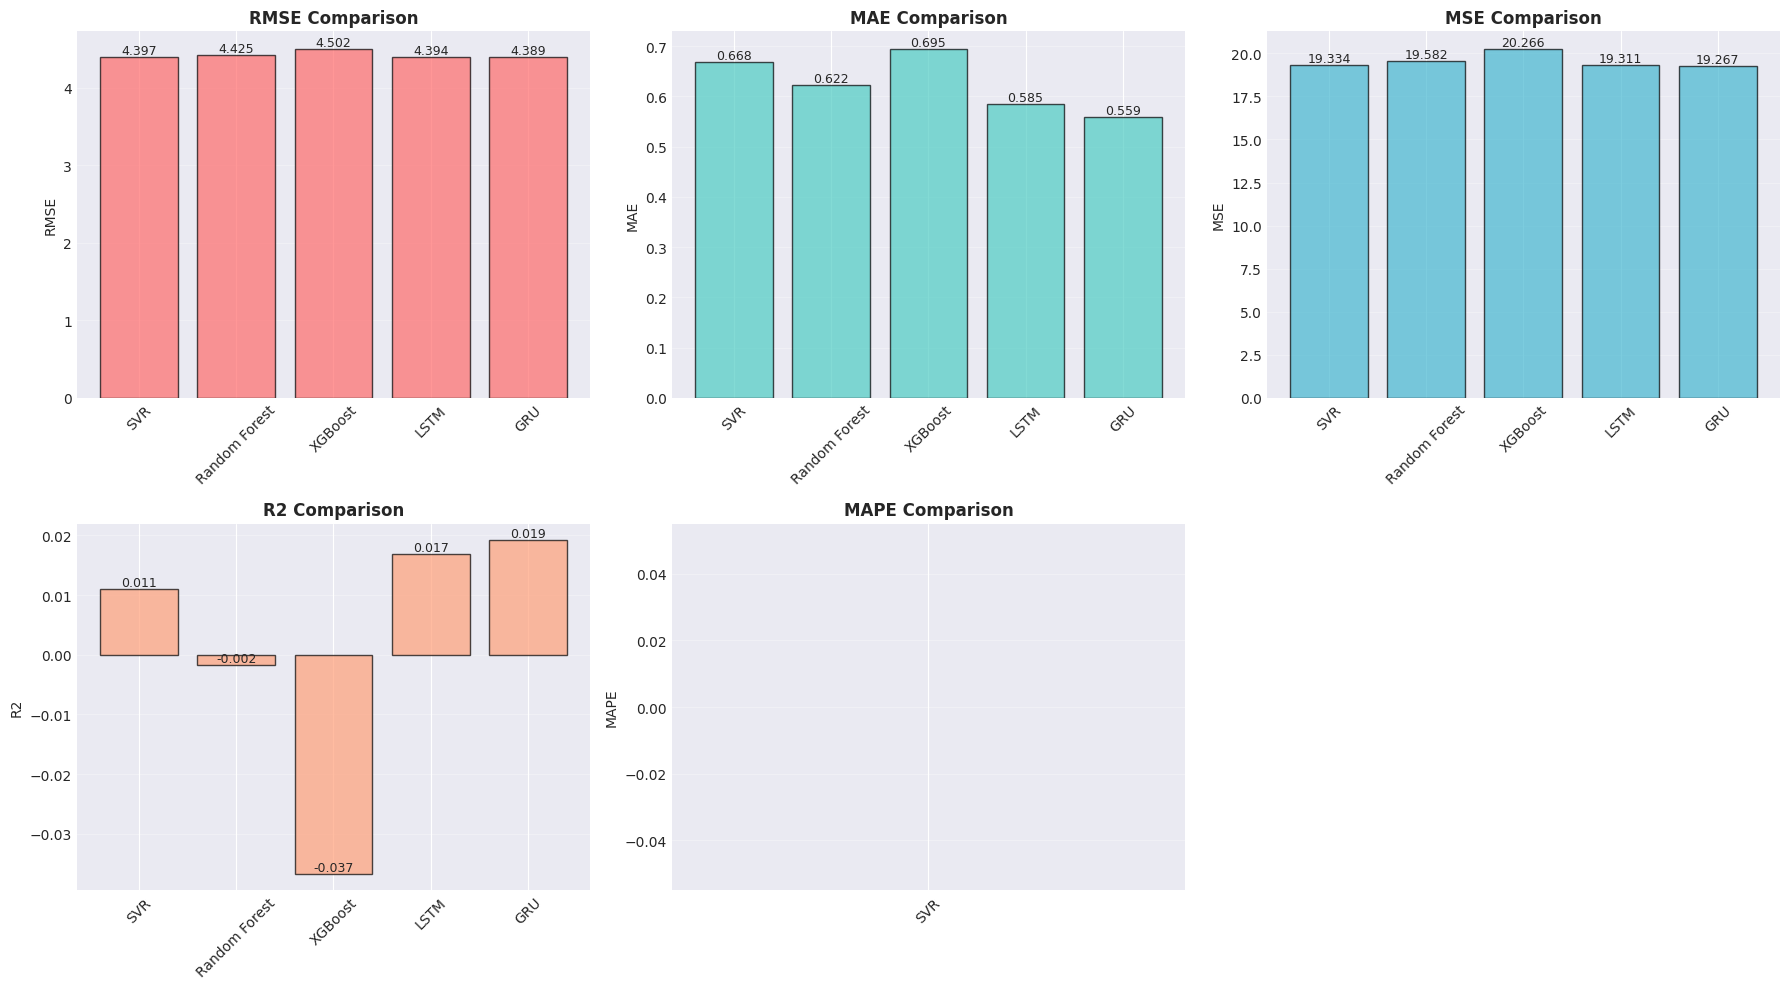

In [24]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics_list = ['RMSE', 'MAE', 'MSE', 'R2', 'MAPE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, metric in enumerate(metrics_list):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    metric_values = [results[model]['Test'][metric] for model in results.keys()]
    bars = ax.bar(results.keys(), metric_values, color=colors[idx], alpha=0.7, edgecolor='black')
    
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 9. Prediction Curves

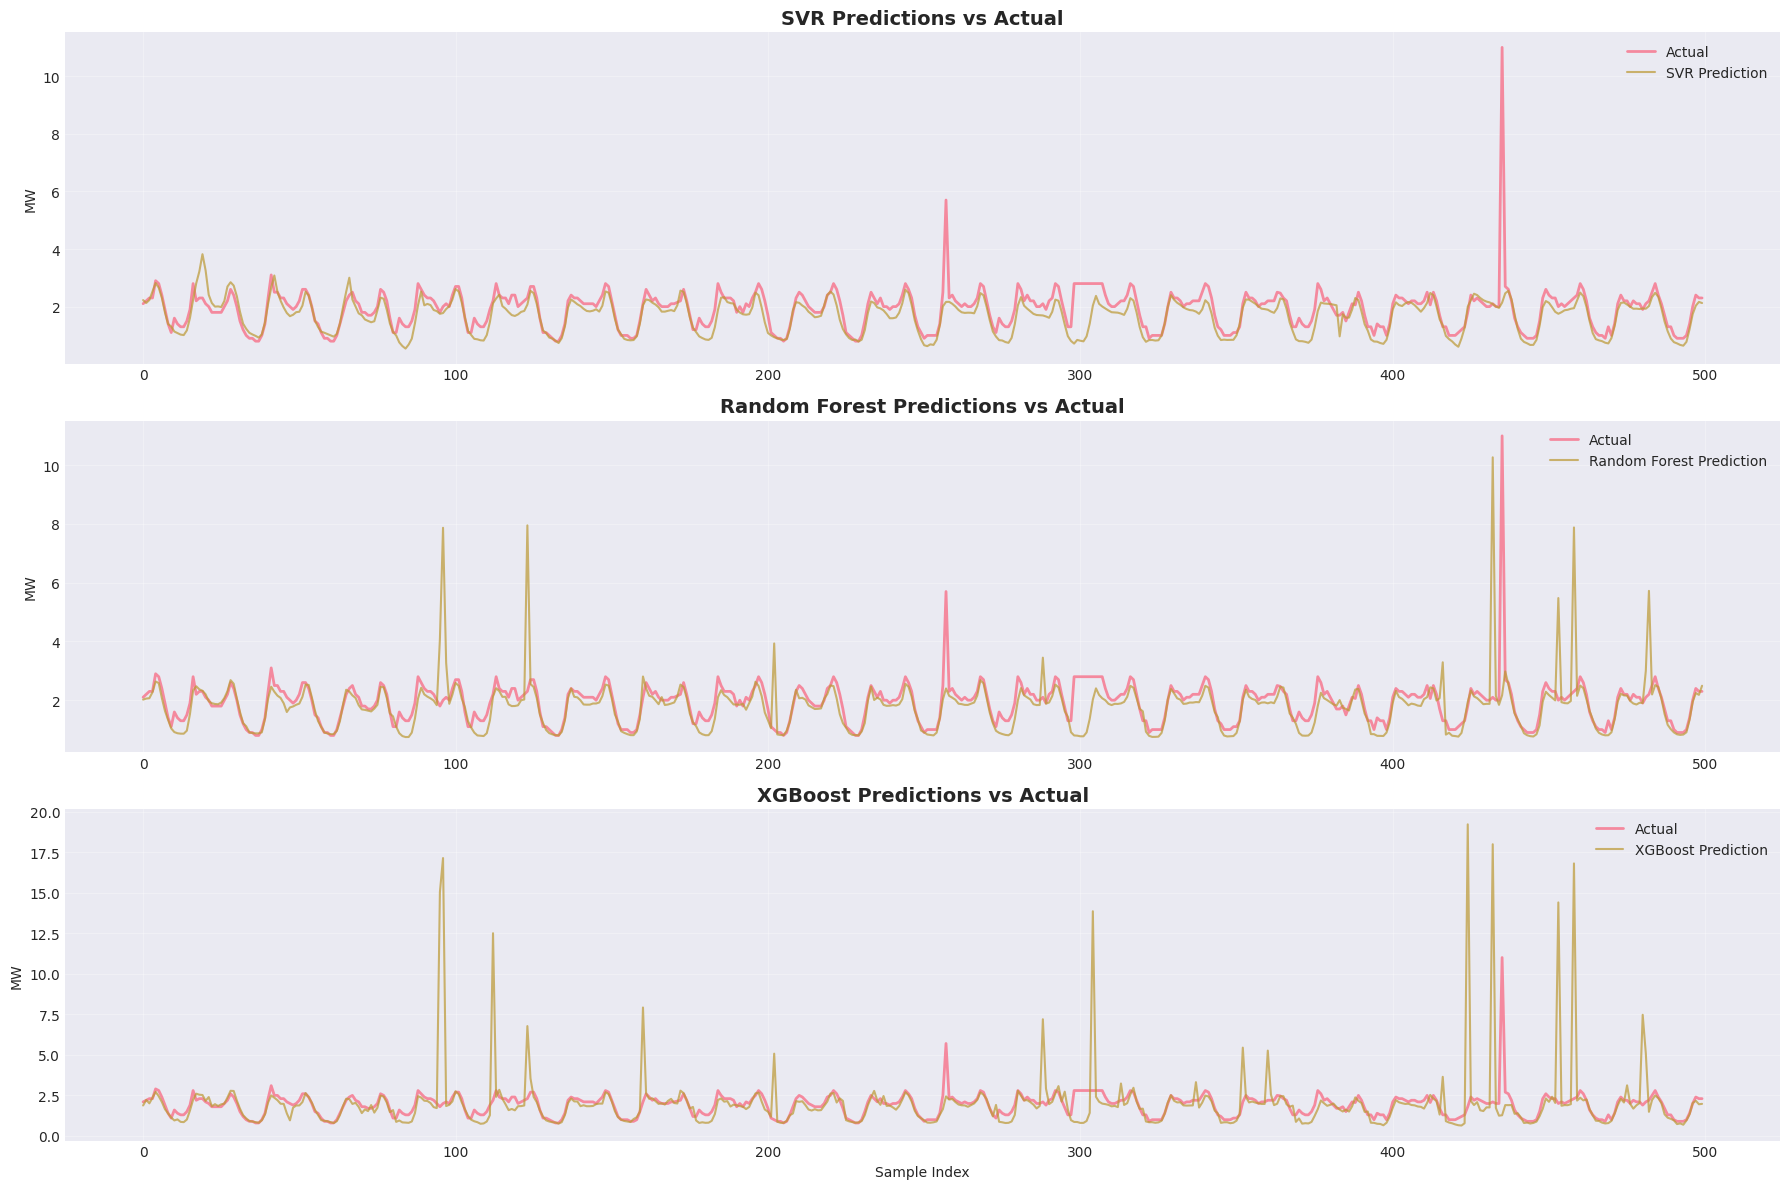

In [25]:
# Plot predictions for ML models (showing first 500 test samples)
n_samples = 500

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# SVR
axes[0].plot(y_test[:n_samples], label='Actual', linewidth=2, alpha=0.8)
axes[0].plot(svr_test_pred[:n_samples], label='SVR Prediction', linewidth=1.5, alpha=0.7)
axes[0].set_title('SVR Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].plot(y_test[:n_samples], label='Actual', linewidth=2, alpha=0.8)
axes[1].plot(rf_test_pred[:n_samples], label='Random Forest Prediction', linewidth=1.5, alpha=0.7)
axes[1].set_title('Random Forest Predictions vs Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MW')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# XGBoost
axes[2].plot(y_test[:n_samples], label='Actual', linewidth=2, alpha=0.8)
axes[2].plot(xgb_test_pred[:n_samples], label='XGBoost Prediction', linewidth=1.5, alpha=0.7)
axes[2].set_title('XGBoost Predictions vs Actual', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('MW')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

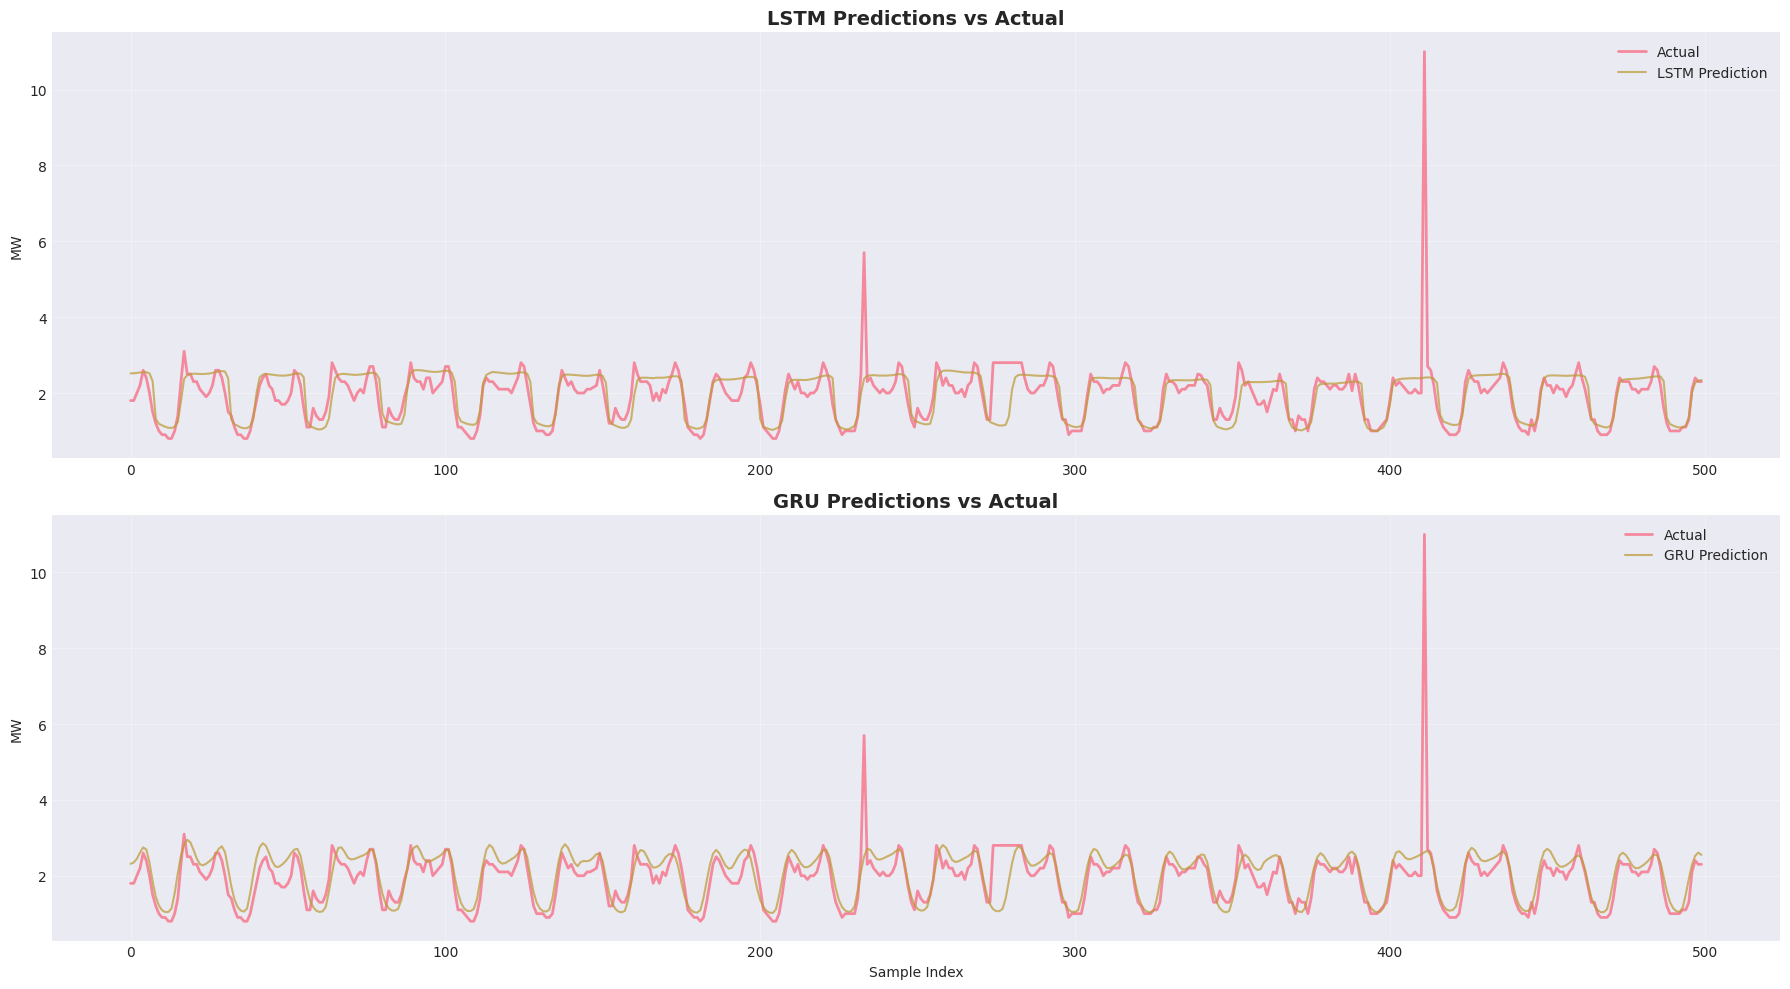

In [26]:
# Plot predictions for DL models
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# LSTM
axes[0].plot(y_test_seq[:n_samples], label='Actual', linewidth=2, alpha=0.8)
axes[0].plot(lstm_test_pred[:n_samples], label='LSTM Prediction', linewidth=1.5, alpha=0.7)
axes[0].set_title('LSTM Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MW')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GRU
axes[1].plot(y_test_seq[:n_samples], label='Actual', linewidth=2, alpha=0.8)
axes[1].plot(gru_test_pred[:n_samples], label='GRU Prediction', linewidth=1.5, alpha=0.7)
axes[1].set_title('GRU Predictions vs Actual', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('MW')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

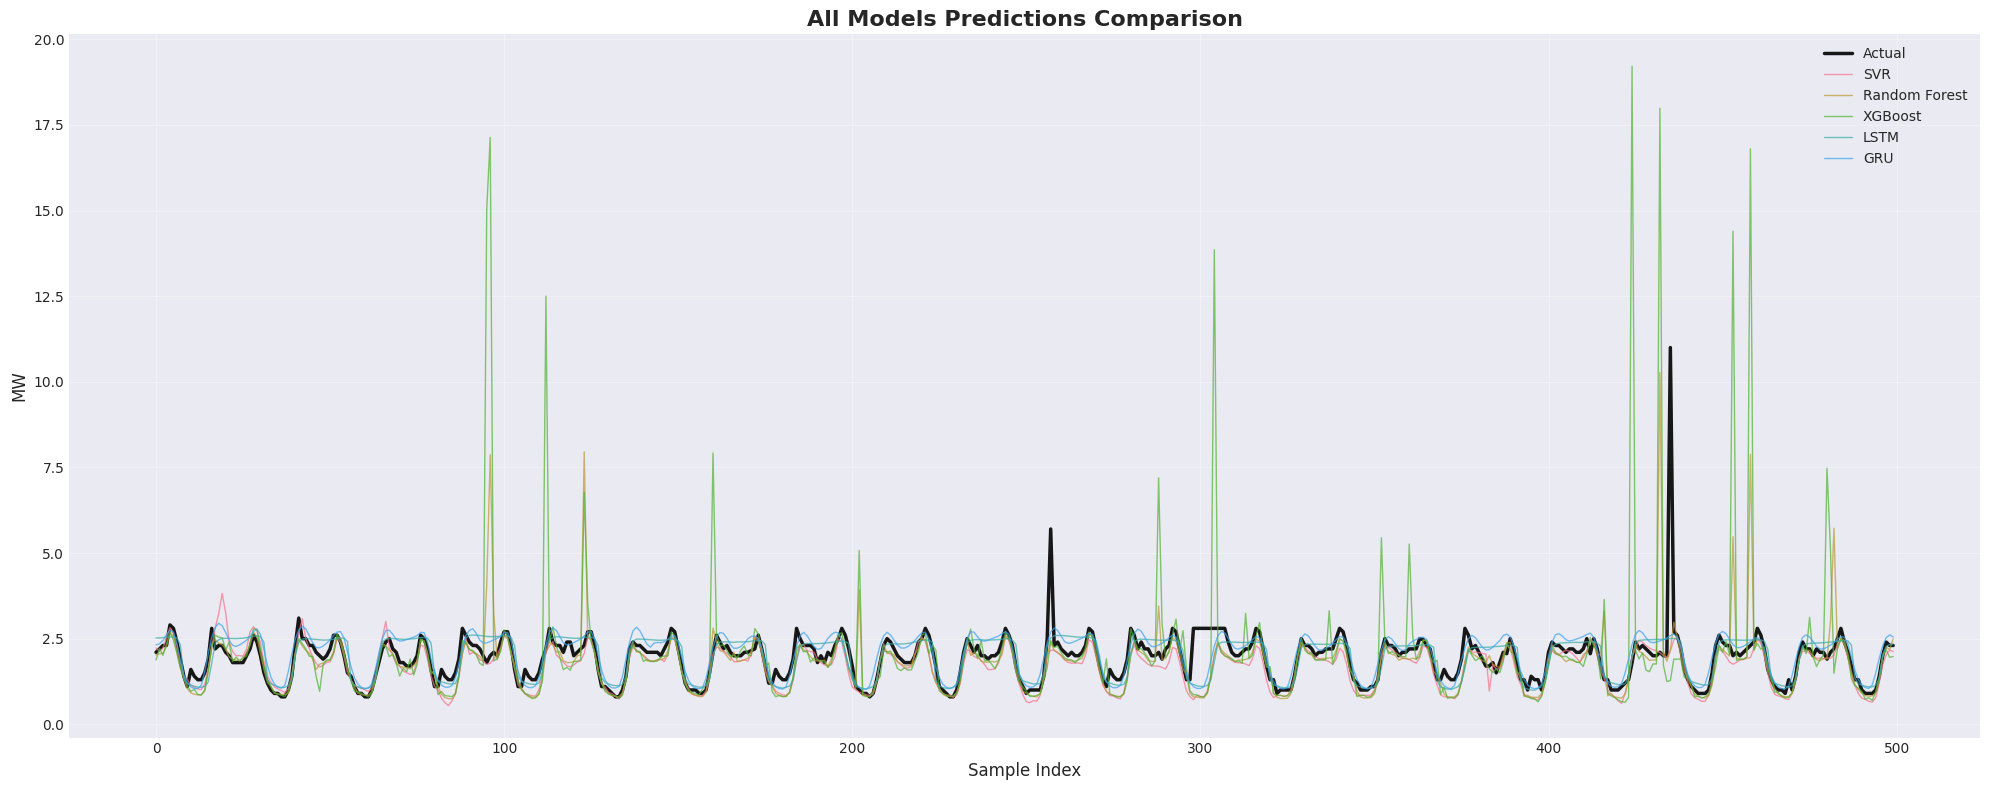

In [27]:
# Compare all models on same plot
plt.figure(figsize=(20, 8))
plt.plot(y_test[:n_samples], label='Actual', linewidth=2.5, alpha=0.9, color='black')
plt.plot(svr_test_pred[:n_samples], label='SVR', linewidth=1, alpha=0.7)
plt.plot(rf_test_pred[:n_samples], label='Random Forest', linewidth=1, alpha=0.7)
plt.plot(xgb_test_pred[:n_samples], label='XGBoost', linewidth=1, alpha=0.7)
plt.plot(lstm_test_pred[:n_samples], label='LSTM', linewidth=1, alpha=0.7)
plt.plot(gru_test_pred[:n_samples], label='GRU', linewidth=1, alpha=0.7)
plt.title('All Models Predictions Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('MW', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

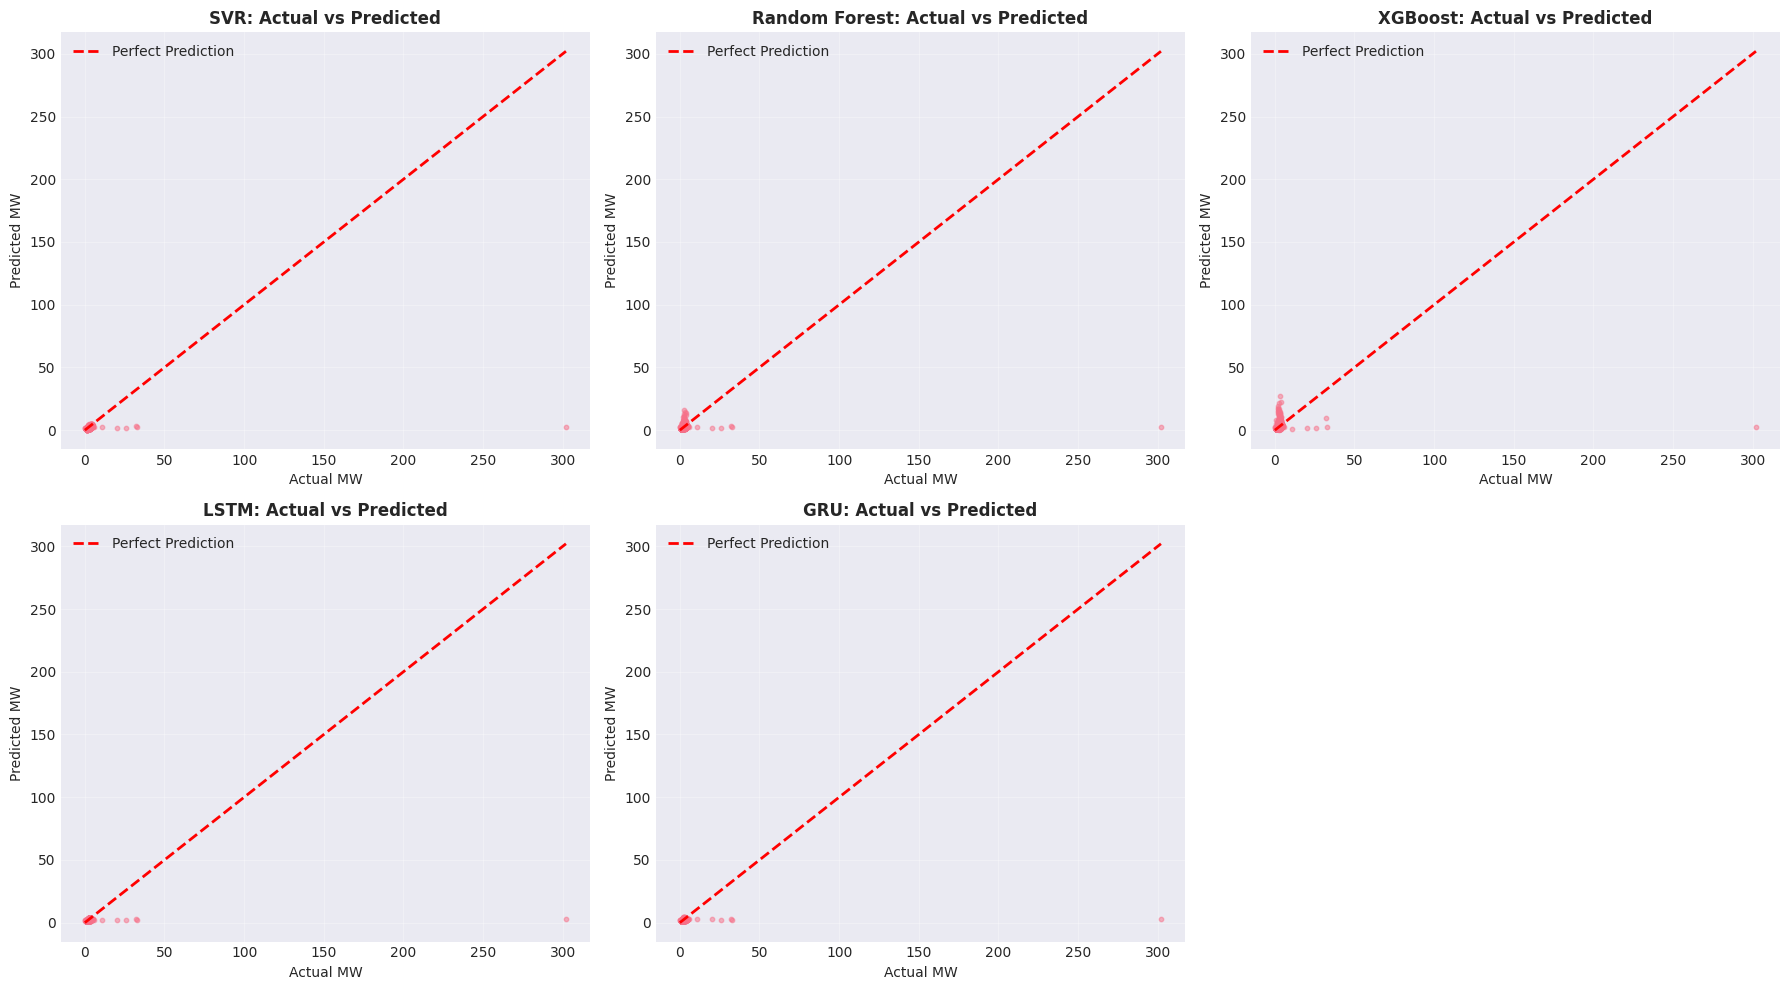

In [28]:
# Scatter plots: Actual vs Predicted
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models_pred = [
    ('SVR', svr_test_pred),
    ('Random Forest', rf_test_pred),
    ('XGBoost', xgb_test_pred),
    ('LSTM', lstm_test_pred),
    ('GRU', gru_test_pred)
]

for idx, (name, pred) in enumerate(models_pred):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    if name in ['LSTM', 'GRU']:
        y_actual = y_test_seq
    else:
        y_actual = y_test
    
    ax.scatter(y_actual, pred, alpha=0.5, s=10)
    ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 
            'r--', linewidth=2, label='Perfect Prediction')
    ax.set_title(f'{name}: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual MW')
    ax.set_ylabel('Predicted MW')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 10. Interactive Prediction System

In [29]:
def predict_mw(air_temp, solar_radiation, humidity, hour, day, month, day_of_week, day_of_year, model='XGBoost'):
    """
    Predict MW consumption based on input parameters
    
    Parameters:
    - air_temp: Air Temperature (°C)
    - solar_radiation: Global Solar Radiation (W/m²)
    - humidity: Relative Humidity (%)
    - hour: Hour of day (0-23)
    - day: Day of month (1-31)
    - month: Month (1-12)
    - day_of_week: Day of week (0=Monday, 6=Sunday)
    - day_of_year: Day of year (1-365)
    - model: Model to use ('SVR', 'Random Forest', 'XGBoost', 'LSTM', 'GRU')
    
    Returns:
    - Predicted MW value
    """
    # Calculate cyclical features
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    
    # Create feature array
    features = np.array([[air_temp, solar_radiation, humidity, hour, day, month, 
                         day_of_week, day_of_year, hour_sin, hour_cos, month_sin, month_cos]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction based on selected model
    if model == 'SVR':
        prediction = svr_model.predict(features_scaled)[0]
    elif model == 'Random Forest':
        prediction = rf_model.predict(features_scaled)[0]
    elif model == 'XGBoost':
        prediction = xgb_model.predict(features_scaled)[0]
    else:
        print(f"Note: {model} requires sequential data. Using XGBoost instead.")
        prediction = xgb_model.predict(features_scaled)[0]
    
    return prediction

print('Prediction function created successfully!')
print('\nUsage example:')
print('predict_mw(air_temp=15.0, solar_radiation=100, humidity=85, hour=14, day=15, month=6, day_of_week=2, day_of_year=166)')

Prediction function created successfully!

Usage example:
predict_mw(air_temp=15.0, solar_radiation=100, humidity=85, hour=14, day=15, month=6, day_of_week=2, day_of_year=166)


In [30]:
# Example predictions
print('\n' + '='*80)
print('EXAMPLE PREDICTIONS')
print('='*80)

# Example 1: Morning, low solar radiation
print('\nExample 1: Morning (8 AM), Low Solar Radiation')
pred1 = predict_mw(air_temp=15.0, solar_radiation=50, humidity=80, 
                   hour=8, day=15, month=6, day_of_week=2, day_of_year=166, model='XGBoost')
print(f'Predicted MW: {pred1:.2f}')

# Example 2: Afternoon, high solar radiation
print('\nExample 2: Afternoon (2 PM), High Solar Radiation')
pred2 = predict_mw(air_temp=28.0, solar_radiation=800, humidity=45, 
                   hour=14, day=15, month=6, day_of_week=2, day_of_year=166, model='XGBoost')
print(f'Predicted MW: {pred2:.2f}')

# Example 3: Night, no solar radiation
print('\nExample 3: Night (10 PM), No Solar Radiation')
pred3 = predict_mw(air_temp=18.0, solar_radiation=0, humidity=75, 
                   hour=22, day=15, month=6, day_of_week=2, day_of_year=166, model='XGBoost')
print(f'Predicted MW: {pred3:.2f}')

print('\n' + '='*80)


EXAMPLE PREDICTIONS

Example 1: Morning (8 AM), Low Solar Radiation
Predicted MW: 2.27

Example 2: Afternoon (2 PM), High Solar Radiation
Predicted MW: 2.26

Example 3: Night (10 PM), No Solar Radiation
Predicted MW: 1.69



In [31]:
# Interactive prediction interface
print('\n' + '='*80)
print('INTERACTIVE MW PREDICTION SYSTEM')
print('='*80)
print('\nEnter the following parameters to predict MW consumption:\n')

# You can uncomment and modify these lines for interactive input
# air_temp = float(input('Air Temperature (°C): '))
# solar_radiation = float(input('Global Solar Radiation (W/m²): '))
# humidity = float(input('Relative Humidity (%): '))
# hour = int(input('Hour (0-23): '))
# day = int(input('Day of month (1-31): '))
# month = int(input('Month (1-12): '))
# day_of_week = int(input('Day of week (0=Mon, 6=Sun): '))
# day_of_year = int(input('Day of year (1-365): '))
# model_choice = input('Model (SVR/Random Forest/XGBoost): ') or 'XGBoost'

# For demonstration, using default values
air_temp = 20.0
solar_radiation = 400
humidity = 65
hour = 12
day = 15
month = 6
day_of_week = 2
day_of_year = 166
model_choice = 'XGBoost'

print(f'\nInput Parameters:')
print(f'Air Temperature: {air_temp}°C')
print(f'Solar Radiation: {solar_radiation} W/m²')
print(f'Humidity: {humidity}%')
print(f'Hour: {hour}')
print(f'Day: {day}')
print(f'Month: {month}')
print(f'Day of Week: {day_of_week}')
print(f'Day of Year: {day_of_year}')
print(f'Model: {model_choice}')

prediction = predict_mw(air_temp, solar_radiation, humidity, hour, day, month, 
                       day_of_week, day_of_year, model=model_choice)

print(f'\n{"="*80}')
print(f'PREDICTED MW CONSUMPTION: {prediction:.2f} MW')
print(f'{"="*80}')


INTERACTIVE MW PREDICTION SYSTEM

Enter the following parameters to predict MW consumption:


Input Parameters:
Air Temperature: 20.0°C
Solar Radiation: 400 W/m²
Humidity: 65%
Hour: 12
Day: 15
Month: 6
Day of Week: 2
Day of Year: 166
Model: XGBoost

PREDICTED MW CONSUMPTION: 2.00 MW


## 11. Summary and Conclusions

In [32]:
print('\n' + '='*80)
print('PROJECT SUMMARY')
print('='*80)

print('\n1. Dataset:')
print(f'   - Total samples: {len(data)}')
print(f'   - Features: Air Temperature, Global Solar Radiation, Relative Humidity, Time-based features')
print(f'   - Target: MW (Megawatt consumption)')
print(f'   - Training samples: {X_train.shape[0]}')
print(f'   - Testing samples: {X_test.shape[0]}')

print('\n2. Models Implemented:')
print('   Machine Learning:')
print('   - Support Vector Regression (SVR)')
print('   - Random Forest Regressor')
print('   - XGBoost Regressor')
print('   Deep Learning:')
print('   - LSTM (Long Short-Term Memory)')
print('   - GRU (Gated Recurrent Unit)')

print('\n3. Best Performing Model:')
best_model = comparison_df.iloc[0]
print(f'   Model: {best_model["Model"]}')
print(f'   RMSE: {best_model["RMSE"]:.4f}')
print(f'   MAE: {best_model["MAE"]:.4f}')
print(f'   R²: {best_model["R2"]:.4f}')
print(f'   MAPE: {best_model["MAPE"]:.2f}%')

print('\n4. Key Features Contributing to Predictions:')
print('   - Hour of day (strong correlation with MW consumption)')
print('   - Air Temperature')
print('   - Global Solar Radiation')
print('   - Month and seasonal patterns')

print('\n5. Evaluation Metrics Used:')
print('   - RMSE: Root Mean Square Error')
print('   - MAE: Mean Absolute Error')
print('   - MSE: Mean Square Error')
print('   - R²: R-squared (Coefficient of Determination)')
print('   - MAPE: Mean Absolute Percentage Error')

print('\n' + '='*80)
print('PROJECT COMPLETED SUCCESSFULLY!')
print('='*80)


PROJECT SUMMARY

1. Dataset:
   - Total samples: 24528
   - Features: Air Temperature, Global Solar Radiation, Relative Humidity, Time-based features
   - Target: MW (Megawatt consumption)
   - Training samples: 19622
   - Testing samples: 4906

2. Models Implemented:
   Machine Learning:
   - Support Vector Regression (SVR)
   - Random Forest Regressor
   - XGBoost Regressor
   Deep Learning:
   - LSTM (Long Short-Term Memory)
   - GRU (Gated Recurrent Unit)

3. Best Performing Model:
   Model: GRU
   RMSE: 4.3894
   MAE: 0.5595
   R²: 0.0191
   MAPE: inf%

4. Key Features Contributing to Predictions:
   - Hour of day (strong correlation with MW consumption)
   - Air Temperature
   - Global Solar Radiation
   - Month and seasonal patterns

5. Evaluation Metrics Used:
   - RMSE: Root Mean Square Error
   - MAE: Mean Absolute Error
   - MSE: Mean Square Error
   - R²: R-squared (Coefficient of Determination)
   - MAPE: Mean Absolute Percentage Error

PROJECT COMPLETED SUCCESSFULLY!
